In [15]:
from datasets import load_dataset
import csv

english_dataset = load_dataset("csv", data_files="../../data/train.tsv", split="train", delimiter='\t', quoting=csv.QUOTE_NONE)
german_dataset = load_dataset("parquet", data_files="../../external_data/German/NottDeuYTSch/NottDeuYTSch_Corpus.parquet", split="train")
finnish_dataset = load_dataset("csv", data_files="../../external_data/Finnish/suomi24-2021-2023-vrt/data/s24_2021.csv", split="train")

In [16]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google/gemma-3-270m")

In [17]:
def get_text_length(example):
    text = example["text"]
    tokenized = tokenizer(text, truncation=False)
    example["length"] = len(tokenized['input_ids'])
    return example

# English

In [18]:
english_dataset

Dataset({
    features: ['id', 'text', 'label'],
    num_rows: 99000
})

In [19]:
english_dataset[0]

{'id': 'eng_train0',
 'text': "I supported Barack Obama. I thought it was absurdity and harassment that conservatives kept pestering Obama about his birth certificate, medical records, tax returns, school transcripts, family tree, DNA, dental records, fingerprints, etc. It was proof of their desire to strip Obama of any dignity. But! I didn't care about Obama's tax returns, stamp collections, third grade report card, etc, and I don't care about Trump's tax returns, third grade report card, or stamp collection, either. There was already enough public information based on their political experience (or lack thereof), public policy positions, campaign style, etc. for me to vote for Obama and against Trump without me needing to know any of that information.",
 'label': 0}

In [20]:
english_dataset = english_dataset.add_column("lang", ["en" for _ in range(len(english_dataset))])

In [21]:
english_dataset = english_dataset.map(get_text_length)

In [22]:
# remove timestamp samples
english_dataset = english_dataset.filter(lambda x: '<c>' not in x['text'])

Filter: 100%|██████████| 99000/99000 [00:00<00:00, 160336.50 examples/s]


In [23]:
english_dataset

Dataset({
    features: ['id', 'text', 'label', 'lang', 'length'],
    num_rows: 98981
})

In [24]:
max(english_dataset['length'])

560

In [25]:
english_dataset.features

{'id': Value('string'),
 'text': Value('string'),
 'label': Value('int64'),
 'lang': Value('string'),
 'length': Value('int64')}

# German

In [26]:
german_sampled = german_dataset.shuffle(seed=42).select(range(99_000))

In [27]:
def convert_german_sample(example, idx):
    new_example = {}
    new_example["id"] = f"ger_train{idx}"
    new_example["text"] = example["textClean"]
    new_example["label"] = -1
    new_example["lang"] = "de"
    return new_example

In [28]:
german_sampled = german_sampled.map(convert_german_sample, with_indices=True, batched=False, remove_columns=german_sampled.column_names)

In [29]:
german_sampled[6]

{'id': 'ger_train6',
 'text': 'Mit Germanletsplay und Paluten würde ich mir es richtig wünschen',
 'label': -1,
 'lang': 'de'}

In [30]:
from datasets import Value
def normalize_features(dataset):
    """Cast large_string columns to string for schema alignment."""
    new_features = dataset.features.copy()
    for col, feature in new_features.items():
        if hasattr(feature, 'dtype') and feature.dtype == 'large_string':
            new_features[col] = Value('string')
    return dataset.cast(new_features)

In [31]:
german_sampled = normalize_features(german_sampled)

In [33]:
german_sampled = german_sampled.map(get_text_length)

Map: 100%|██████████| 99000/99000 [00:15<00:00, 6396.48 examples/s]


In [35]:
# Remove too long text
german_sampled = german_sampled.filter(lambda x: x['length'] <= 300)

Filter: 100%|██████████| 99000/99000 [00:00<00:00, 224254.36 examples/s]


In [37]:
german_sampled

Dataset({
    features: ['id', 'text', 'label', 'lang', 'length'],
    num_rows: 98833
})

In [47]:
max(german_sampled['length'])

299

In [36]:
german_sampled.features

{'id': Value('string'),
 'text': Value('string'),
 'label': Value('int64'),
 'lang': Value('string'),
 'length': Value('int64')}

# Finnish

In [38]:
finnish_sampled = finnish_dataset.shuffle(seed=42).select(range(99_000))

In [39]:
def convert_finnish_sample(example, idx):
    new_example = {}
    new_example["id"] = f"fin_train{idx}"
    new_example["text"] = example["text"]
    new_example["label"] = -1
    new_example["lang"] = "fi"
    return new_example

In [40]:
finnish_sampled = finnish_sampled.map(convert_finnish_sample, with_indices=True, batched=False, remove_columns=finnish_sampled.column_names)

In [41]:
finnish_sampled[19]

{'id': 'fin_train19',
 'text': 'Suomi on jakautunut kahtia , Kela-Suomi ja muu Suomi . Edellämainitulla menee vielä toistaiseksi hyvin .',
 'label': -1,
 'lang': 'fi'}

In [43]:
finnish_sampled = finnish_sampled.map(get_text_length)

Map: 100%|██████████| 99000/99000 [00:25<00:00, 3849.39 examples/s]


In [45]:
# Remove too long text
finnish_sampled = finnish_sampled.filter(lambda x: x['length'] <= 1024)

Filter: 100%|██████████| 99000/99000 [00:00<00:00, 155745.05 examples/s]


In [46]:
max(finnish_sampled['length'])

1024

In [54]:
finnish_sampled.features

{'id': Value('string'),
 'text': Value('string'),
 'label': Value('int64'),
 'lang': Value('string'),
 'length': Value('int64')}

# Combine

In [55]:
finnish_sampled

Dataset({
    features: ['id', 'text', 'label', 'lang', 'length'],
    num_rows: 98772
})

In [56]:
german_sampled

Dataset({
    features: ['id', 'text', 'label', 'lang', 'length'],
    num_rows: 98833
})

In [57]:
english_dataset

Dataset({
    features: ['id', 'text', 'label', 'lang', 'length'],
    num_rows: 98981
})

In [58]:
from datasets import concatenate_datasets

final_dataset = concatenate_datasets([english_dataset, german_sampled, finnish_sampled])

In [59]:
final_dataset

Dataset({
    features: ['id', 'text', 'label', 'lang', 'length'],
    num_rows: 296586
})

# Remove emoji

In [1]:
from datasets import load_dataset

final_dataset = load_dataset("parquet", data_files="../../data/train_combined.parquet", split="train")

/home/thang/MasterDegree/Aalto/Study/NaturalLanguageProcessing/Project/ToxicityDetection/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import emoji

def get_emoji_proportion(text):
    """Calculate the proportion of emoji characters in text."""
    if not text or len(text) == 0:
        return 0.0
    
    emoji_count = sum(1 for char in text if char in emoji.EMOJI_DATA)
    return emoji_count / len(text)

In [16]:
filtered_dataset = final_dataset.filter(
    lambda example: get_emoji_proportion(example['text']) <= 0.3
)

Filter: 100%|██████████| 296586/296586 [00:03<00:00, 79441.49 examples/s] 


In [17]:
filtered_dataset

Dataset({
    features: ['id', 'text', 'label', 'lang', 'length'],
    num_rows: 292231
})

In [18]:
lang = filtered_dataset['lang']

In [19]:
from collections import Counter

c = Counter(lang)
print(c)

Counter({'en': 98980, 'fi': 98569, 'de': 94682})


In [20]:
filtered_dataset

Dataset({
    features: ['id', 'text', 'label', 'lang', 'length'],
    num_rows: 292231
})

In [21]:
filtered_dataset.to_csv("../../data/train_combined.csv")
filtered_dataset.to_parquet("../../data/train_combined.parquet")

Creating parquet from Arrow format: 100%|██████████| 293/293 [00:08<00:00, 33.81ba/s]


63782684

# Analyze

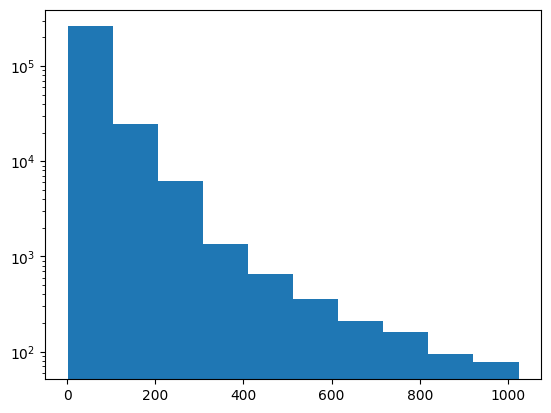

In [15]:
import matplotlib.pyplot as plt

plt.hist(filtered_dataset['length'])
plt.yscale('log')